In [1]:
from brian2 import *
from QIF import Neuron_QIF
from QIF_DOP import Neuron_QIF_DOP
from simulation_runner import run_simulation
from synapse import SynapseModel, connect
from params import load_params

In [2]:
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
# from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

In [3]:
def main():
    # Define parameters for NeuronModel
    params = load_params('./SPN.json')
    N = params.pop('N')
    
    # Define v_reset
    v_reset = -66 * mV
    
    # Run the simulation
    run_simulation(N, params, v_reset)

Earliest time when v stabilizes at v_reset (in ms): 12.9 s


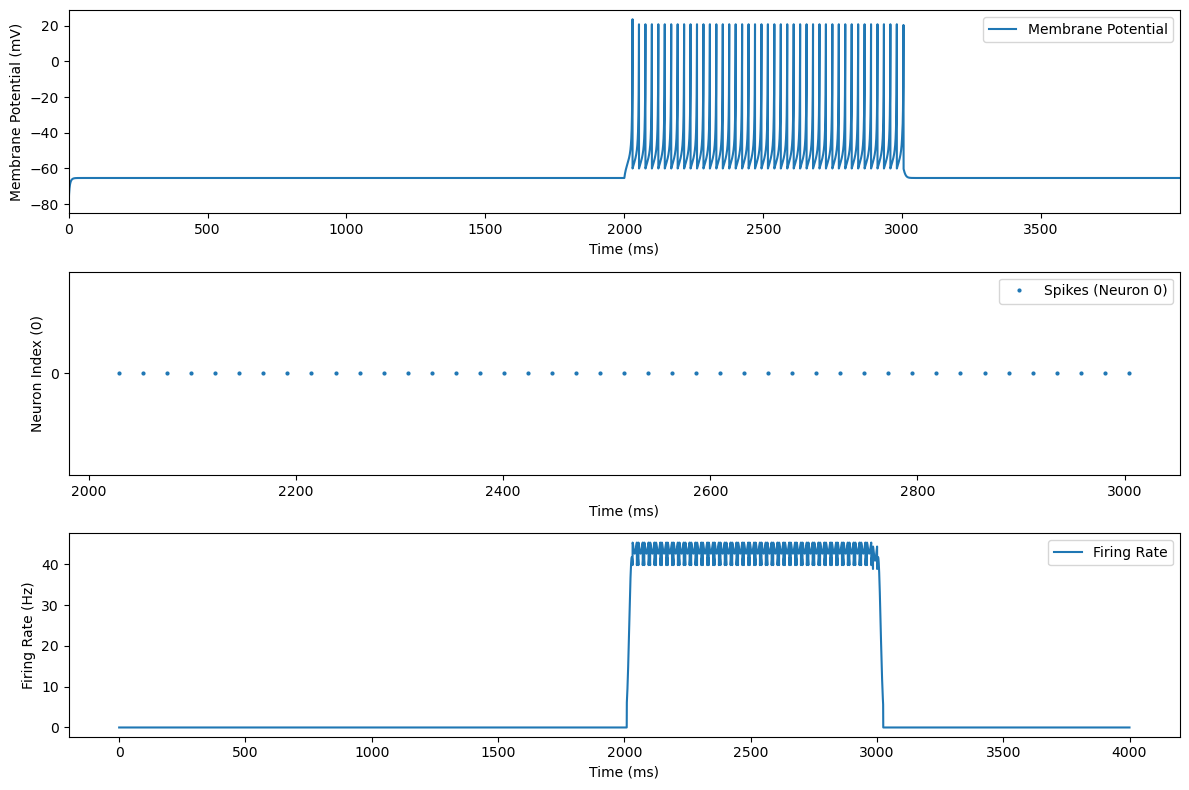

In [4]:
# with dopamine
if __name__ == '__main__':
    main()

In [3]:
def main():
    # Define parameters for NeuronModel
    params = load_params('./QIF.json')
    N = params.pop('N')
    
    # Define v_reset
    v_reset = -66 * mV
    
    # Run the simulation
    run_simulation(N, params, v_reset)

Earliest time when v stabilizes at v_reset (in ms): 9. s


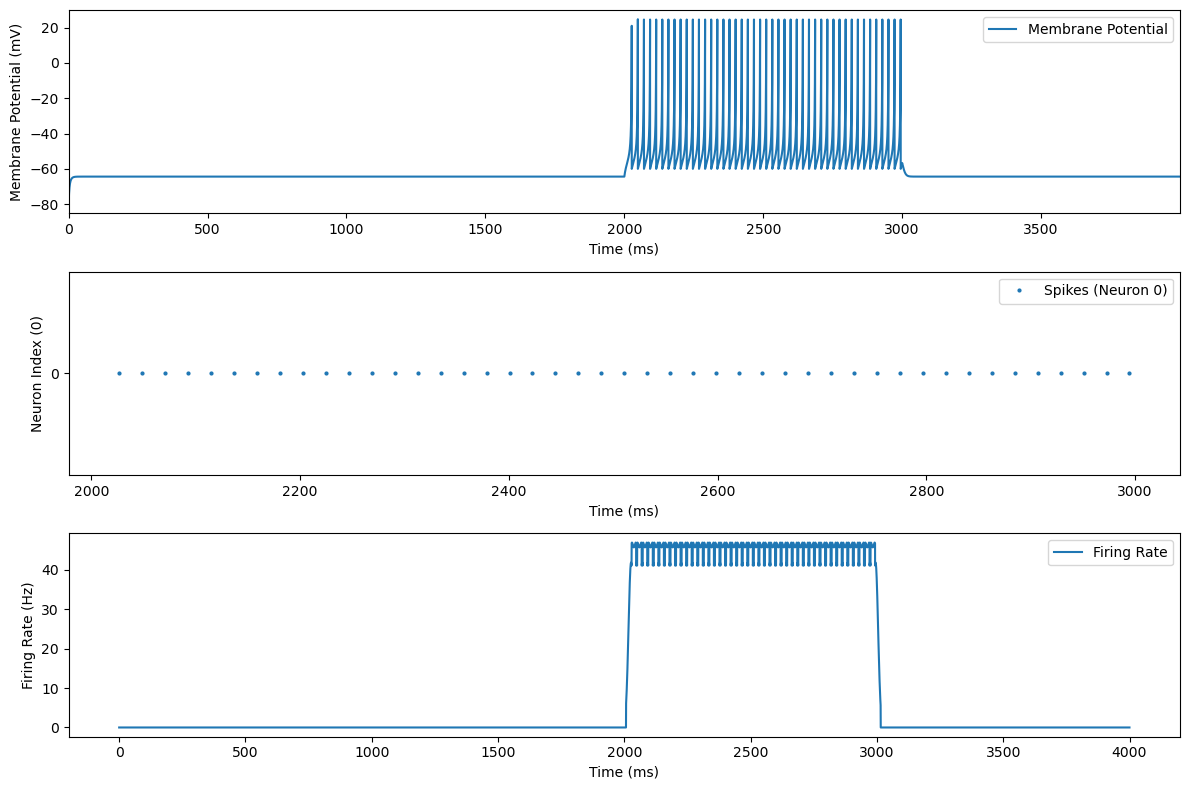

In [4]:
# withouyt dopamine
if __name__ == '__main__':
    main()